In [32]:
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import sklearn.tree as tree
import pandas as pd
import numpy as np

## Load the dataset

In [26]:
adult = fetch_ucirepo(id=2)
X_original = adult.data.features
y_original = adult.data.targets
print(X_original)
print(y_original)

       age         workclass  fnlwgt  education  education-num  \
0       39         State-gov   77516  Bachelors             13   
1       50  Self-emp-not-inc   83311  Bachelors             13   
2       38           Private  215646    HS-grad              9   
3       53           Private  234721       11th              7   
4       28           Private  338409  Bachelors             13   
...    ...               ...     ...        ...            ...   
48837   39           Private  215419  Bachelors             13   
48838   64               NaN  321403    HS-grad              9   
48839   38           Private  374983  Bachelors             13   
48840   44           Private   83891  Bachelors             13   
48841   35      Self-emp-inc  182148  Bachelors             13   

           marital-status         occupation    relationship  \
0           Never-married       Adm-clerical   Not-in-family   
1      Married-civ-spouse    Exec-managerial         Husband   
2              

## Part 1: age, hours-per-week, and income

First, we need to extract age and work hours.

In [27]:
X_age = np.array(X_original)[:20000,0]
X_wh = np.array(X_original)[:20000,12]
X = np.column_stack((X_age, X_wh))
print(X)
y = np.array(y_original)[:20000]
y_cleaned = np.array([label[0].replace('.', '') for label in y])
encoder = LabelEncoder()
y = encoder.fit_transform(y_cleaned)
print(y)

[[39 40]
 [50 13]
 [38 40]
 ...
 [72 99]
 [54 44]
 [30 40]]
[0 0 0 ... 0 1 1]


In [28]:
X = pd.DataFrame(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = 2*y - 1
print(X_scaled)
print(y)

[[ 0.02961142 -0.03230868]
 [ 0.83476689 -2.23128626]
 [-0.04358453 -0.03230868]
 ...
 [ 2.44507783  4.77286455]
 [ 1.1275507   0.29346577]
 [-0.62915214 -0.03230868]]
[-1 -1 -1 ... -1  1  1]


In [29]:
X_age = np.array(X_original)[:20000,0]  # age
X_edu = np.array(X_original)[:20000,4]  # education-num
X_sex = np.array(X_original)[:20000,9]  # sex
X_hours = np.array(X_original)[:20000,12]  # hours-per-week
X_marital = np.array(X_original)[:20000,5]  # marital-status
X_selected = np.column_stack((X_age, X_edu, X_sex, X_hours, X_marital))
X_selected = pd.DataFrame(X_selected, columns=['age', 'education-num', 'sex', 'hours-per-week', 'marital-status'])

# Encode categorical variables
label_encoder = LabelEncoder()
X_selected['sex'] = label_encoder.fit_transform(X_selected['sex'])
X_selected['marital-status'] = label_encoder.fit_transform(X_selected['marital-status'])

# Scale the features
scaler = StandardScaler()
X_selected_scaled = scaler.fit_transform(X_selected)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled, y, test_size=0.3, random_state=42)


### Linear Regression


Linear Regression Results:
Coefficients: [ 0.15150536  0.2488241   0.13063162  0.10788532 -0.07952674]
Intercept: -0.5233440244189612
Score: 0.21678827079590157


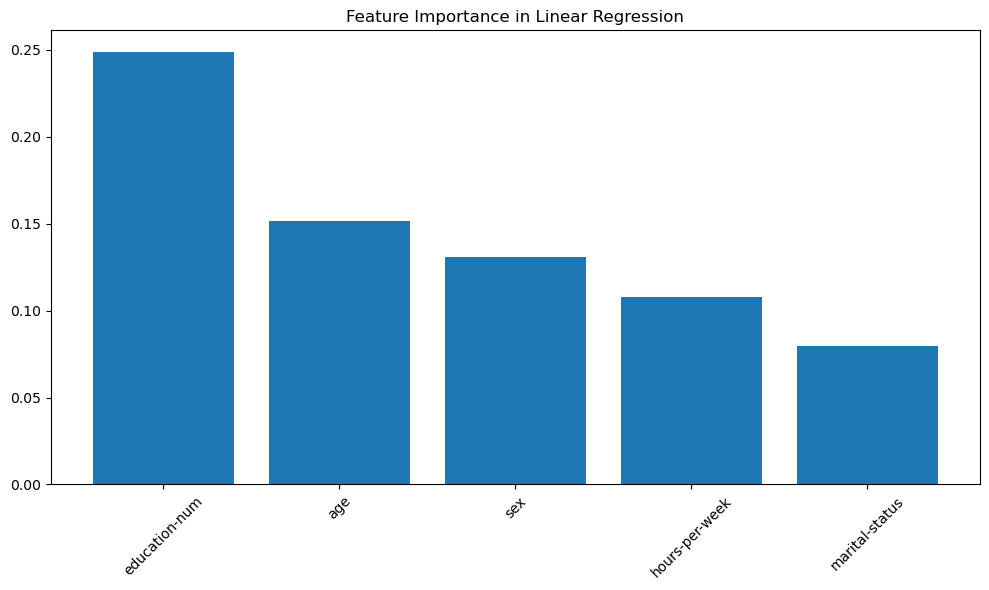

In [34]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
print("\nLinear Regression Results:")
print("Coefficients:", lr_model.coef_)
print("Intercept:", lr_model.intercept_)
print("Score:", lr_model.score(X_test, y_test))

plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'feature': ['age', 'education-num', 'sex', 'hours-per-week', 'marital-status'],
    'importance': abs(lr_model.coef_)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=45)
plt.title('Feature Importance in Linear Regression')
plt.tight_layout()
plt.show()


### KNN Classification


KNN Classification Results:
Accuracy: 0.8151666666666667

Classification Report:
              precision    recall  f1-score   support

          -1       0.87      0.90      0.88      4566
           1       0.63      0.56      0.59      1434

    accuracy                           0.82      6000
   macro avg       0.75      0.73      0.74      6000
weighted avg       0.81      0.82      0.81      6000



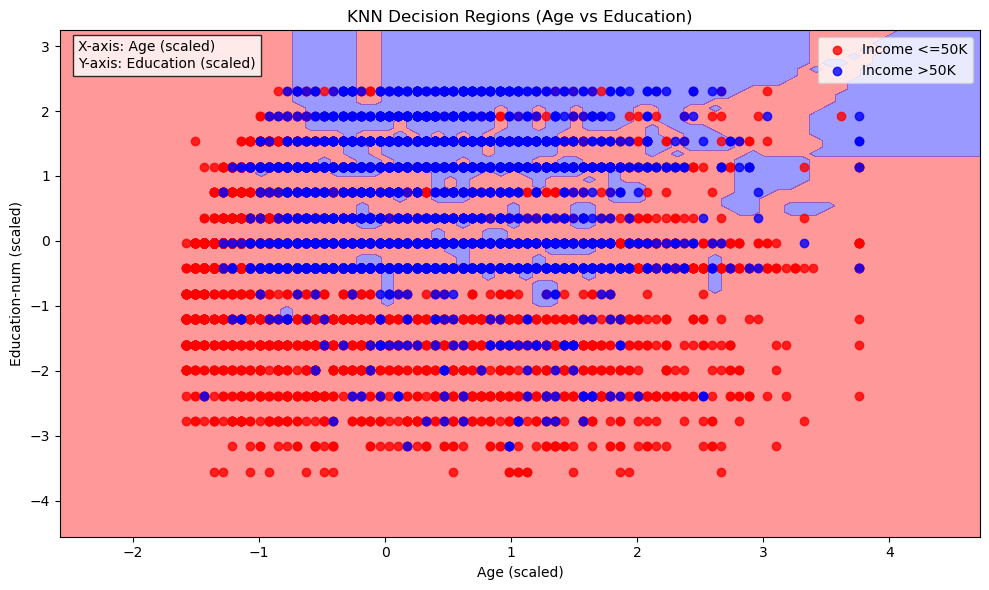

In [38]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

print("\nKNN Classification Results:")
print("Accuracy:", accuracy_score(y_test, knn_pred))
print("\nClassification Report:")
print(classification_report(y_test, knn_pred))

plt.figure(figsize=(10, 6))
X_subset = X_selected_scaled[:, [0, 1]]  
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset, y, test_size=0.3, random_state=42)

knn_subset = KNeighborsClassifier(n_neighbors=5)
knn_subset.fit(X_train_subset, y_train_subset)

x_min, x_max = X_subset[:, 0].min() - 1, X_subset[:, 0].max() + 1
y_min, y_max = X_subset[:, 1].min() - 1, X_subset[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = knn_subset.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Create contour plot with distinct colors
plt.contourf(xx, yy, Z, alpha=0.4, levels=[-2,0,2], colors=['red', 'blue'])

# Create scatter plot with distinct colors for each class
mask_low = y_train_subset == -1
mask_high = y_train_subset == 1

plt.scatter(X_train_subset[mask_low, 0], X_train_subset[mask_low, 1], 
           c='red', label='Income <=50K', alpha=0.8)
plt.scatter(X_train_subset[mask_high, 0], X_train_subset[mask_high, 1], 
           c='blue', label='Income >50K', alpha=0.8)

plt.xlabel('Age (scaled)')
plt.ylabel('Education-num (scaled)')
plt.title('KNN Decision Regions (Age vs Education)')

# Add legend
plt.legend()

# Add text to explain the axes
plt.text(0.02, 0.98, 'X-axis: Age (scaled)\nY-axis: Education (scaled)', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()

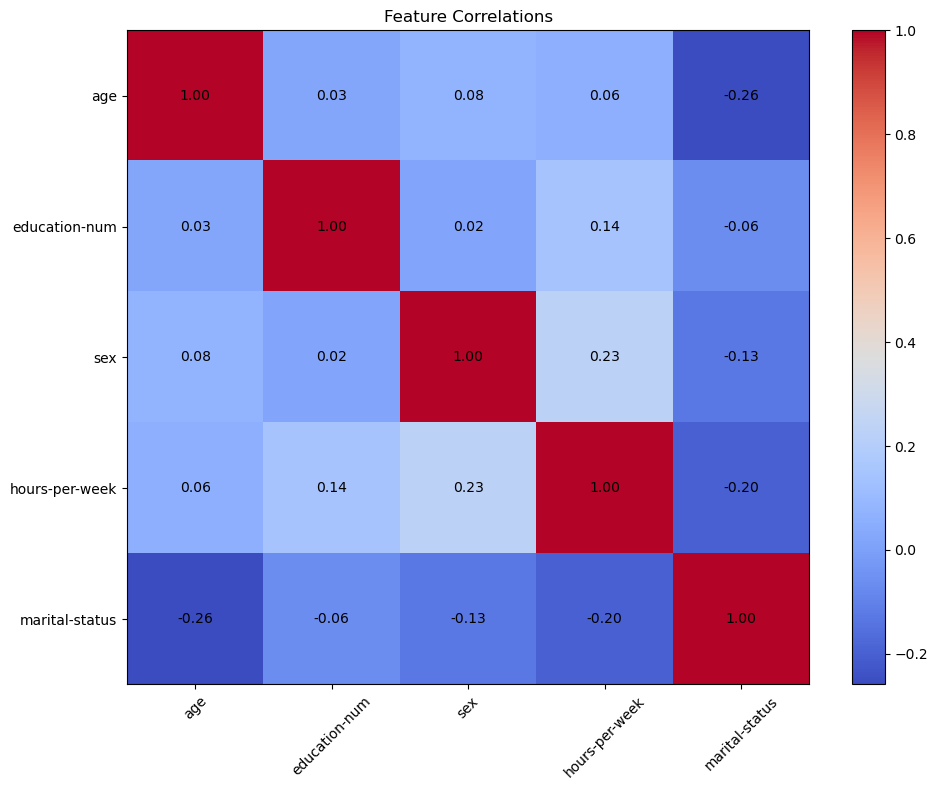

In [36]:
# Feature correlations
plt.figure(figsize=(10, 8))
correlation_matrix = X_selected.corr()
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(X_selected.columns)), X_selected.columns, rotation=45)
plt.yticks(range(len(X_selected.columns)), X_selected.columns)
plt.title('Feature Correlations')
for i in range(len(X_selected.columns)):
    for j in range(len(X_selected.columns)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", 
                ha='center', va='center')
plt.tight_layout()
plt.show()

### Logistic Regression

In [22]:
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 2000],
    'eta0': [0.01, 0.1, 0.001],
    'learning_rate': ['constant', 'adaptive'],
}

grid_search = GridSearchCV(SGDClassifier(loss='log_loss', random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("best param:", grid_search.best_params_)

model2 = SGDClassifier(
    loss='log_loss',
    learning_rate=grid_search.best_params_['learning_rate'],
    eta0=grid_search.best_params_['eta0'],
    max_iter=grid_search.best_params_['max_iter'],
    tol=0.1,
    random_state=42,
    alpha=grid_search.best_params_['alpha']
)
model2.fit(X_test, y_test)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

best param: {'alpha': 0.01, 'eta0': 0.01, 'learning_rate': 'constant', 'max_iter': 1000}


NameError: name 'model' is not defined

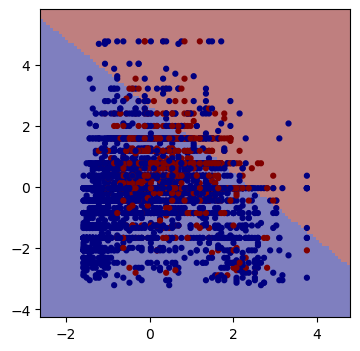

In [ ]:
plot_kwargs = {'cmap': 'jet',
               'response_method': 'predict',
               'plot_method': 'pcolormesh',
               'shading': 'auto',
               'alpha': 0.5,
               'grid_resolution': 100}
figure, axes = plt.subplots(1, 1, figsize=(4,4))
DecisionBoundaryDisplay.from_estimator(model2, X_train, ax=axes, **plot_kwargs)
axes.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor=None, s=12, cmap='jet')
plt.show()

SVM

In [ ]:
degrees=[1,2,5,20]
figure,axes = plt.subplots(1,4,figsize=(12,3))

for i,d in enumerate(degrees):
    
# Each item in the pipeline is a pair, (name, transform); the end is (name, learner):
    learner = Pipeline( [('poly',PolynomialFeatures(degree=d)),
                         ('scale',StandardScaler()), 
                         ('logreg',SGDClassifier(loss='log_loss',
                                                 penalty='l2',alpha=1e-20,
                                                 learning_rate='adaptive', eta0=1e-2,
                                                 tol=0.,max_iter=100000,n_iter_no_change=1000))
                        ])

    ### YOUR CODE STARTS HERE
    learner.fit(X_train,y)
    # Fit the model
    DecisionBoundaryDisplay.from_estimator(learner, X, **plot_kwargs, ax=axes[i])
    axes[i].scatter(X_train[:, 0], X_train[:, 1], c=y, edgecolor=None, s=12, cmap='jet')
    axes[i].set_title(f'{d} degree')

## Part 2: race vs income

### Sophisticated decision tree structures

In [7]:
X_label = np.array(X_original)[:20000,8]
X_label

array(['White', 'White', 'White', ..., 'White', 'White', 'White'],
      dtype=object)

In [9]:
encoder = LabelEncoder()
labels = encoder.fit_transform(X_label)
print(labels)

[4 4 4 ... 4 4 4]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(labels, y, test_size=0.3, random_state=42)

In [14]:

dt = tree.DecisionTreeClassifier(max_depth=100, criterion='entropy', random_state=42)
dt.fit(X_train, y_train)
train_preds = dt.predict(X_train)
val_preds = dt.predict(X_test)
train_error = np.mean(y_train != train_preds)
val_error = np.mean(y_test != val_preds)
print(f"Training Error Rate: {train_error:.4f}")
print(f"Validation Error Rate: {val_error:.4f}")

Training Error Rate: 0.2001
Validation Error Rate: 0.2470


In [15]:
tree.plot_tree(dt, feature_names=X_label.columns, class_names=['<=50K', '>50K'], filled=True)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'